<a href="https://colab.research.google.com/github/ykitaguchi77/YOLACT_Mobius/blob/main/YOLOv8_inference_LR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mobius YOLO8 inference (左右判定あり)**

```
# Classes
names:
  0: eyelid_R
  1: iris_R
  2: pupil_R
  3: eyelid_L
  4: iris_L
  5: pupil_L
```

In [1]:
import cv2
from google.colab import drive
import shutil
import os

#driveのマウント
drive.mount('/content/drive')

!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics

Mounted at /content/drive
Cloning into 'ultralytics'...
remote: Enumerating objects: 43834, done.
remote: Counting objects: 100% (1645/1645), done.
remote: Compressing objects: 100% (998/998), done.
remote: Total 43834 (delta 1119), reused 1025 (delta 637), pack-reused 42189 (from 1)
Receiving objects: 100% (43834/43834), 38.54 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (32409/32409), done.
/content/ultralytics


### Unilateral model

In [6]:
#yolov8
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training_LR/ultralytics/runs/segment/train4/weights/best.pt")
#model = YOLO("/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training/ultralytics/runs/segment/train3_458epochs/weights/best.pt")


# # ディレクトリパスを設定
# image_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/images/val"
# # ディレクトリ内の画像ファイルを取得
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
# img_path = image_files[13]

img_path = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/10.jpg"

results = model(img_path, save=False, save_txt=False)  # predict on an image


image 1/1 /content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/10.jpg: 640x640 1 eyelid, 1 iris, 1 pupil, 281.8ms
Speed: 5.5ms preprocess, 281.8ms inference, 19.6ms postprocess per image at shape (1, 3, 640, 640)


In [3]:
# 元のクラスをマージ後のクラスにマッピング
merged_classes = {
    0: "eyelid",  # クラス0を新しいクラス0に
    1: "iris",  # クラス1を新しいクラス0にマージ
    2: "pupil",   # クラス2は新しいクラス1として保持
}

# クラス名ごとの色を定義
class_colors = {
    "eyelid": (255, 0, 0),   # 赤
    "iris": (0, 255, 0),     # 緑
    "pupil": (0, 0, 255),    # 青
}


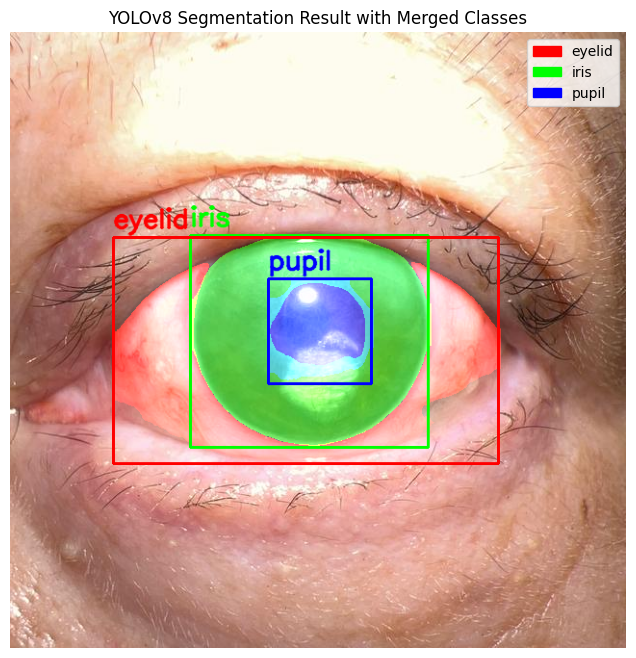

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# クラスインデックスをクラス名にマッピング
merged_classes = {
    0: "eyelid",
    1: "iris",
    2: "pupil",
}

# クラス名ごとの色を定義
class_colors = {
    "eyelid": (255, 0, 0),   # 赤
    "iris": (0, 255, 0),     # 緑
    "pupil": (0, 0, 255),    # 青
}

# クラス名のリストを取得
unique_classes = list(set(merged_classes.values()))

# 画像を読み込む
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"画像が見つかりませんでした: {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 結果を取得
result = results[0]

# マスクとボックスを取得
masks = result.masks.data.cpu().numpy()  # マスクのリスト
boxes = result.boxes.data.cpu().numpy()  # ボックスのリスト

# セグメンテーションマスクを重ねる
for i, mask in enumerate(masks):
    original_cls = int(boxes[i, 5])  # 元のクラスインデックス
    class_name = merged_classes.get(original_cls, "unknown")  # クラス名を取得
    color = class_colors.get(class_name, (255, 255, 255))  # クラス名に対応する色を取得（デフォルトは白）

    mask = mask.astype(np.uint8) * 255

    # マスクを元の画像のサイズにリサイズ
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    colored_mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    colored_mask[mask > 0] = color

    # マスクを画像にブレンド (50%の透過度)
    img = cv2.addWeighted(img, 1, colored_mask, 0.5, 0)

# バウンディングボックスを描画
for box in boxes:
    x1, y1, x2, y2 = map(int, box[:4])
    original_cls = int(box[5])
    class_name = merged_classes.get(original_cls, "unknown")
    color = class_colors.get(class_name, (255, 255, 255))
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    # クラス名をバウンディングボックスに表示
    cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.9, color, 2, cv2.LINE_AA)

# 凡例の作成
legend_patches = [mpatches.Patch(color=np.array(color)/255, label=cls) for cls, color in class_colors.items()]

# 結果を表示
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.legend(handles=legend_patches, loc='upper right')
plt.title('YOLOv8 Segmentation Result with Merged Classes')
plt.show()


### Bilateral model

In [ ]:
#yolov8
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training_LR/ultralytics/runs/segment/train4/weights/best.pt")

img_path = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/15.jpg"

results = model(img_path, save=False, save_txt=False)  # predict on an image


image 1/1 /content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/15.jpg: 640x640 1 eyelid, 1 iris, 1 pupil, 241.6ms
Speed: 5.0ms preprocess, 241.6ms inference, 16.2ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 元のクラスをマージ後のクラスにマッピング
merged_classes = {
    0: "eyelid_L",
    1: "iris_L",
    2: "pupil_L",
    3: "eyelid_R",
    4: "iris_R",
    5: "pupil_R",
}

# クラス名ごとの色を定義
class_colors = {
    "eyelid_L": (255, 0, 0),   # 赤
    "iris_L": (0, 255, 0),     # 緑
    "pupil_L": (0, 0, 255),    # 青
    "eyelid_R": (255, 0, 0),   # 赤
    "iris_R": (0, 255, 0),     # 緑
    "pupil_R": (0, 0, 255),    # 青
}

# クラス名のリストを取得
unique_classes = list(set(merged_classes.values()))

# 画像を読み込む
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"画像が見つかりませんでした: {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 結果を取得
result = results[0]

# マスクとボックスを取得
masks = result.masks.data.cpu().numpy()  # マスクのリスト
boxes = result.boxes.data.cpu().numpy()  # ボックスのリスト

# セグメンテーションマスクを重ねる
for i, mask in enumerate(masks):
    original_cls = int(boxes[i, 5])  # 元のクラスインデックス
    class_name = merged_classes.get(original_cls, "unknown")  # クラス名を取得
    color = class_colors.get(class_name, (255, 255, 255))  # クラス名に対応する色を取得（デフォルトは白）

    mask = mask.astype(np.uint8) * 255

    # マスクを元の画像のサイズにリサイズ
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    colored_mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    colored_mask[mask > 0] = color

    # マスクを画像にブレンド (50%の透過度)
    img = cv2.addWeighted(img, 1, colored_mask, 0.5, 0)

# バウンディングボックスを描画
for box in boxes:
    x1, y1, x2, y2 = map(int, box[:4])
    original_cls = int(box[5])
    class_name = merged_classes.get(original_cls, "unknown")
    color = class_colors.get(class_name, (255, 255, 255))
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    # クラス名をバウンディングボックスに表示
    cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.9, color, 2, cv2.LINE_AA)

# 凡例の作成
legend_patches = [mpatches.Patch(color=np.array(color)/255, label=cls) for cls, color in class_colors.items()]

# 結果を表示
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.legend(handles=legend_patches, loc='upper right')
plt.title('YOLOv8 Segmentation Result with Merged Classes')
plt.show()


In [ ]:
# yolov8
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# モデルのロード
model = YOLO("/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training_LR/ultralytics/runs/segment/train4/weights/best.pt")

# 画像のパス
img_path = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/images/val/3_1i_Ls_2.jpg"

# 推論の実行
results = model(img_path, save=False, save_txt=False)  # 画像に対して予測を実行

# 元のクラスをマージ後のクラスにマッピング
merged_classes = {
    0: "eyelid_L",
    1: "iris_L",
    2: "pupil_L",
    3: "eyelid_R",
    4: "iris_R",
    5: "pupil_R",
}

# クラス名ごとの色を定義
class_colors = {
    "eyelid_L": (255, 0, 0),   # 赤
    "iris_L": (0, 255, 0),     # 緑
    "pupil_L": (0, 0, 255),    # 青
    "eyelid_R": (255, 0, 0),   # 赤
    "iris_R": (0, 255, 0),     # 緑
    "pupil_R": (0, 0, 255),    # 青
}

# 画像を読み込む
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"画像が見つかりませんでした: {img_path}")
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 元画像を保持
processed_img = original_img.copy()  # セグメンテーション結果用にコピー

# 結果を取得
result = results[0]

# マスクとボックスを取得
masks = result.masks.data.cpu().numpy()  # マスクのリスト
boxes = result.boxes.data.cpu().numpy()  # ボックスのリスト

# セグメンテーションマスクを重ねる
for i, mask in enumerate(masks):
    original_cls = int(boxes[i, 5])  # 元のクラスインデックス
    class_name = merged_classes.get(original_cls, "unknown")  # クラス名を取得
    color = class_colors.get(class_name, (255, 255, 255))  # クラス名に対応する色を取得（デフォルトは白）

    mask = mask.astype(np.uint8) * 255

    # マスクを元の画像のサイズにリサイズ（必要に応じて）
    mask = cv2.resize(mask, (processed_img.shape[1], processed_img.shape[0]))

    colored_mask = np.zeros((processed_img.shape[0], processed_img.shape[1], 3), dtype=np.uint8)
    colored_mask[mask > 0] = color

    # マスクを画像にブレンド (50%の透過度)
    processed_img = cv2.addWeighted(processed_img, 1, colored_mask, 0.5, 0)

# バウンディングボックスを描画
for box in boxes:
    x1, y1, x2, y2 = map(int, box[:4])
    original_cls = int(box[5])
    class_name = merged_classes.get(original_cls, "unknown")
    color = class_colors.get(class_name, (255, 255, 255))
    cv2.rectangle(processed_img, (x1, y1), (x2, y2), color, 2)
    # クラス名をバウンディングボックスに表示
    cv2.putText(processed_img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.9, color, 2, cv2.LINE_AA)

# 凡例の作成
# クラス名と色のペアで重複を避けるためにsetを使用
unique_class_colors = {cls: color for cls, color in class_colors.items()}
legend_patches = [mpatches.Patch(color=np.array(color)/255, label=cls) for cls, color in unique_class_colors.items()]

# 元画像と推論画像を左右に並べて表示
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# 元画像の表示
axes[0].imshow(original_img)
axes[0].axis('off')
axes[0].set_title('元画像')

# 推論結果の表示
axes[1].imshow(processed_img)
axes[1].axis('off')
axes[1].set_title('YOLOv8 Segmentation Result with Merged Classes')
axes[1].legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# 必要なライブラリのインポート
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# モデルのロード
model_path = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training_LR/ultralytics/runs/segment/train4/weights/best.pt"
model = YOLO(model_path)

# 画像ディレクトリの設定
image_dir = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial/"

# 処理する画像の番号リスト
image_numbers = range(1, 21)  # 1 から 20 まで

# 元のクラスをマージ後のクラスにマッピング
merged_classes = {
    0: "eyelid_L",
    1: "iris_L",
    2: "pupil_L",
    3: "eyelid_R",
    4: "iris_R",
    5: "pupil_R",
}

# クラス名ごとの色を定義
class_colors = {
    "eyelid_L": (255, 0, 0),   # 赤
    "iris_L": (0, 255, 0),     # 緑
    "pupil_L": (0, 0, 255),    # 青
    "eyelid_R": (255, 0, 0),   # 赤
    "iris_R": (0, 255, 0),     # 緑
    "pupil_R": (0, 0, 255),    # 青
}

# クラス名のリストを取得
unique_classes = list(set(merged_classes.values()))

# 凡例の作成（クラス名と色のペアで重複を避けるためにsetを使用）
unique_class_colors = {cls: color for cls, color in class_colors.items()}
legend_patches = [mpatches.Patch(color=np.array(color)/255, label=cls) for cls, color in unique_class_colors.items()]

# 各画像に対して処理を実行
for num in image_numbers:
    # 画像ファイル名とパスの作成
    image_filename = f"{num}.jpg"
    img_path = os.path.join(image_dir, image_filename)

    # 画像の存在確認
    if not os.path.exists(img_path):
        print(f"画像が見つかりませんでした: {img_path}")
        continue  # 次の画像へスキップ

    # 推論の実行
    results = model(img_path, save=False, save_txt=False)  # 画像に対して予測を実行

    # 画像を読み込む
    img = cv2.imread(img_path)
    if img is None:
        print(f"画像を読み込めませんでした: {img_path}")
        continue  # 次の画像へスキップ
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 元画像を保持
    processed_img = original_img.copy()  # セグメンテーション結果用にコピー

    # 結果を取得
    result = results[0]

    # マスクとボックスを取得
    masks = result.masks.data.cpu().numpy()  # マスクのリスト
    boxes = result.boxes.data.cpu().numpy()  # ボックスのリスト

    # セグメンテーションマスクを重ねる
    for i, mask in enumerate(masks):
        if i >= len(boxes):
            print(f"マスクの数がボックスの数を超えています: {img_path}")
            break  # マスク数がボックス数を超えた場合、ループを抜ける

        original_cls = int(boxes[i, 5])  # 元のクラスインデックス
        class_name = merged_classes.get(original_cls, "unknown")  # クラス名を取得
        color = class_colors.get(class_name, (255, 255, 255))  # クラス名に対応する色を取得（デフォルトは白）

        mask = mask.astype(np.uint8) * 255

        # マスクを元の画像のサイズにリサイズ（必要に応じて）
        mask = cv2.resize(mask, (processed_img.shape[1], processed_img.shape[0]))

        colored_mask = np.zeros((processed_img.shape[0], processed_img.shape[1], 3), dtype=np.uint8)
        colored_mask[mask > 0] = color

        # マスクを画像にブレンド (50%の透過度)
        processed_img = cv2.addWeighted(processed_img, 1, colored_mask, 0.5, 0)

    # バウンディングボックスを描画
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        original_cls = int(box[5])
        class_name = merged_classes.get(original_cls, "unknown")
        color = class_colors.get(class_name, (255, 255, 255))
        cv2.rectangle(processed_img, (x1, y1), (x2, y2), color, 2)
        # クラス名をバウンディングボックスに表示
        cv2.putText(processed_img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, color, 2, cv2.LINE_AA)

    # 比較用のプロットを作成
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    # 元画像の表示
    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title(f'元画像: {image_filename}', fontsize=16)

    # 推論結果の表示
    axes[1].imshow(processed_img)
    axes[1].axis('off')
    axes[1].set_title(f'YOLOv8 Segmentation Result: {image_filename}', fontsize=16)
    axes[1].legend(handles=legend_patches, loc='upper right', fontsize=12)

    plt.tight_layout()

    # 比較画像の表示
    plt.show()
    plt.close(fig)  # メモリ節約のために図を閉じる

    print(f"処理完了: {image_filename}")

print("全ての画像の処理が完了しました。")


In [ ]:
# yolov8
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# モデルのロード
model = YOLO("/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/YOLOv8_training_LR/ultralytics/runs/segment/train4/weights/best.pt")

# 画像のパス
img_path = "/content/207-20120726-71-113947_63d7786bf09e9fd187213afd8f4a9bf4f6d2c34debc63f34a787364d056d76c1.jpg"

# 推論の実行
results = model(img_path, save=False, save_txt=False)  # 画像に対して予測を実行

# 元のクラスをマージ後のクラスにマッピング
merged_classes = {
    0: "eyelid_L",
    1: "iris_L",
    2: "pupil_L",
    3: "eyelid_R",
    4: "iris_R",
    5: "pupil_R",
}

# クラス名ごとの色を定義
class_colors = {
    "eyelid_L": (255, 0, 0),   # 赤
    "iris_L": (0, 255, 0),     # 緑
    "pupil_L": (0, 0, 255),    # 青
    "eyelid_R": (255, 0, 0),   # 赤
    "iris_R": (0, 255, 0),     # 緑
    "pupil_R": (0, 0, 255),    # 青
}

# 画像を読み込む
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"画像が見つかりませんでした: {img_path}")
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 元画像を保持
processed_img = original_img.copy()  # セグメンテーション結果用にコピー

# 結果を取得
result = results[0]

# マスクとボックスを取得
masks = result.masks.data.cpu().numpy()  # マスクのリスト
boxes = result.boxes.data.cpu().numpy()  # ボックスのリスト

# セグメンテーションマスクを重ねる
for i, mask in enumerate(masks):
    original_cls = int(boxes[i, 5])  # 元のクラスインデックス
    class_name = merged_classes.get(original_cls, "unknown")  # クラス名を取得
    color = class_colors.get(class_name, (255, 255, 255))  # クラス名に対応する色を取得（デフォルトは白）

    mask = mask.astype(np.uint8) * 255

    # マスクを元の画像のサイズにリサイズ（必要に応じて）
    mask = cv2.resize(mask, (processed_img.shape[1], processed_img.shape[0]))

    colored_mask = np.zeros((processed_img.shape[0], processed_img.shape[1], 3), dtype=np.uint8)
    colored_mask[mask > 0] = color

    # マスクを画像にブレンド (50%の透過度)
    processed_img = cv2.addWeighted(processed_img, 1, colored_mask, 0.5, 0)

# バウンディングボックスを描画
for box in boxes:
    x1, y1, x2, y2 = map(int, box[:4])
    original_cls = int(box[5])
    class_name = merged_classes.get(original_cls, "unknown")
    color = class_colors.get(class_name, (255, 255, 255))
    cv2.rectangle(processed_img, (x1, y1), (x2, y2), color, 2)
    # クラス名をバウンディングボックスに表示
    cv2.putText(processed_img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.9, color, 2, cv2.LINE_AA)

# 凡例の作成
# クラス名と色のペアで重複を避けるためにsetを使用
unique_class_colors = {cls: color for cls, color in class_colors.items()}
legend_patches = [mpatches.Patch(color=np.array(color)/255, label=cls) for cls, color in unique_class_colors.items()]

# 元画像と推論画像を左右に並べて表示
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# 元画像の表示
axes[0].imshow(original_img)
axes[0].axis('off')
axes[0].set_title('元画像')

# 推論結果の表示
axes[1].imshow(processed_img)
axes[1].axis('off')
axes[1].set_title('YOLOv8 Segmentation Result with Merged Classes')
axes[1].legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()

# 追加部分: クラスごとに別々の画像を作成して表示
# クラスごとの処理
for class_name, color in unique_class_colors.items():
    # クラス専用の画像をコピー
    class_img = original_img.copy()

    # クラスに属するマスクとボックスをフィルタリング
    class_masks = []
    class_boxes = []
    for i, mask in enumerate(masks):
        original_cls = int(boxes[i, 5])
        cls_name = merged_classes.get(original_cls, "unknown")
        if cls_name == class_name:
            class_masks.append(mask)
            class_boxes.append(boxes[i])

    # マスクを適用
    for mask in class_masks:
        mask = mask.astype(np.uint8) * 255
        mask = cv2.resize(mask, (class_img.shape[1], class_img.shape[0]))
        colored_mask = np.zeros((class_img.shape[0], class_img.shape[1], 3), dtype=np.uint8)
        colored_mask[mask > 0] = color
        class_img = cv2.addWeighted(class_img, 1, colored_mask, 0.5, 0)

    # バウンディングボックスを描画
    for box in class_boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(class_img, (x1, y1), (x2, y2), color, 2)
        # クラス名をバウンディングボックスに表示
        cv2.putText(class_img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, color, 2, cv2.LINE_AA)

    # 画像を表示
    plt.figure(figsize=(12, 6))
    plt.imshow(class_img)
    plt.axis('off')
    plt.title(f'Class: {class_name}')
    plt.show()
